# Assignment 2

This assignment is about training and evaluating a POS tagger with some real data. The dataset is available through the Universal Dependencies (https://universaldependencies.org/) (UD) project. To get to know the project, please visit https://universaldependencies.org/introduction.html)

Do make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.

In [ ]:
#!pip install --q conllutils

In [2]:
import os
import random
from typing import List

import nltk
import operator

import numpy as np
import pandas as pd
from tabulate import tabulate

import conllutils

## Part 1 - Dataset





For each package you use, set the random seed to 42.

In [5]:
# Set the random seed for Python
random.seed(42)

# Set the random seed for numpy
np.random.seed(42)

# Set the random seed for pandas
#TODO

# Set the random seed for NLTK
#TODO

You can download the dataset files directly from the UD website, but it will let you only download all the languages in one compressed file. In this assignment you will be working with th GUM dataset, which you can download directly from:
https://github.com/UniversalDependencies/UD_English-GUM.
Please download it to your colab machine.

In [4]:
#!git clone https://github.com/UniversalDependencies/UD_English-GUM

We will use the (train/dev/test) files:


```
UD_English-GUM/en_gum-ud-train.conllu
UD_English-GUM/en_gum-ud-dev.conllu
UD_English-GUM/en_gum-ud-test.conllu
```


They are all formatted in the conllu format. You may read about it [here](https://universaldependencies.org/format.html). There is a utility library **conllutils**, which can help you read the data into the memory. It has already been installed and imported above.

You should write a code that reads the three datasets into memory. You may choose the data structure by yourself. As you can see, every word is represented by a line, with columns representing specific features. We are only interested in the first and fourth columns, corresponding to the word and its POS tag.

In [24]:
# Preparing pipeline for sentence pre-processing
# At first, we will create a pipeline for pre-processing of sentences, which will:
#
# 1. Filter only syntactic words (i.e. skip the empty and multiword tokens).
# 2. Extract only Universal dependency relations without the language-specific extensions.
# 3. Generate a concatenated UPOS & FEATS field.
# 4. Transform FORM values to lowercase.
# 5. Replace numbers expressions in FORM field with the constant value.
from conllutils import pipe

NUM_REGEX = r'[0-9]+|[0-9]+\.[0-9]+|[0-9]+[0-9,]+'
NUM_FORM = '__number__'

p = pipe()
p.only_words()
p.only_universal_deprel()
p.upos_feats()
p.lowercase('form')
p.replace('form', NUM_REGEX, NUM_FORM)


In [43]:
train_data,test_data, dev_data = None, None, None

# TODO:
# set the file paths for the train, dev, and test datasets
train_path = 'UD_English-GUM/en_gum-ud-train.conllu'
dev_path = 'UD_English-GUM/en_gum-ud-dev.conllu'
test_path = 'UD_English-GUM/en_gum-ud-test.conllu'

# read the datasets into memory
train_index = pipe().read_conllu(train_path).pipe(p).create_index()
train_data = pipe().read_conllu(train_path).pipe(p).to_instance(train_index).collect()

dev_index = pipe().read_conllu(dev_path).pipe(p).create_index()
dev_data = pipe().read_conllu(dev_path).pipe(p).to_instance(dev_index).collect()

test_index = pipe().read_conllu(test_path).pipe(p).create_index()
test_data = pipe().read_conllu(test_path).pipe(p).to_instance(test_index).collect()



In [50]:
# print size of each dataset
print(f"Train size: {len(train_data)}")
print(f"Dev size: {len(dev_data)}")
print(f"Test size: {len(test_data)}")

# print keys of the index
print(f"Index keys: {train_index.keys()}")

#print the keys of the first instance
print(f"Instance keys: {train_data[0].keys()}")

# print the first instance
print(f"First instance: {train_data[0]}")

# print index values for the first instance
print(f"First instance index values: {train_data[0].values()}")



Train size: 6911
Dev size: 1117
Test size: 1096
Index keys: dict_keys(['form', 'lemma', 'upos', 'xpos', 'feats', 'deprel', 'deps', 'misc', 'upos_feats'])
Instance keys: dict_keys(['deprel', 'upos_feats', 'xpos', 'head', 'upos', 'form', 'feats', 'lemma', 'deps', 'misc'])
First instance: {'deprel': array([ 7,  6, 13,  7, 11,  1], dtype=int64), 'upos_feats': array([5, 2, 8, 5, 2, 1], dtype=int64), 'xpos': array([ 5,  1, 12,  5,  1, 22], dtype=int64), 'head': array([2, 0, 5, 5, 2, 2], dtype=int64), 'upos': array([ 7,  1, 11,  7,  1,  2], dtype=int64), 'form': array([2424, 2852,    4,  521,  306,   54], dtype=int64), 'feats': array([ 2,  1, -1,  2,  1, -1], dtype=int64), 'lemma': array([2185, 2514,    5,  585,  394,   51], dtype=int64), 'deps': array([186,   1, 261,  83, 170,   3], dtype=int64), 'misc': array([29110,     4,    -1, 19209,    26,    -1], dtype=int64)}
First instance index values: dict_values([array([ 7,  6, 13,  7, 11,  1], dtype=int64), array([5, 2, 8, 5, 2, 1], dtype=int64)

## Part 2 - Simpler Tagger

Write a class **simple_tagger**, with methods `train` and `evaluate`. 

The method `train` receives the data, and use it for training the tagger.   
In this case, it should learn a simple dictionary that **maps words to tags**, defined as the most frequent tag for every word (in case there is more than one most frequent tag, you may select one of them randomly). The dictionary should be stored as a class member for evaluation.

The method `evaluate` receives the data, and use it to evaluate the tagger performance. Specifically, you should calculate the word and sentence level accuracy.
The evaluation process is simply going word by word, querying the dictionary (created by the train method) for each word’s tag and compare it to the true tag of that word. 
 - The word-level accuracy is the number of successes divided by the number of words. For OOV (out of vocabulary, or unknown) words, the tagger should assign the most frequent tag in the entire training set (i.e., the mode). 
 - Calculate the sentence-level accuracy by dividing the number of correctly predicted sentences by the total number of sentences in the dataset.

The function should return the two numbers: word level accuracy and sentence level accuracy.

<br>

Notes:  
 - You may add functions to `simple_tagger`. 
 - Avoid using loops except when absolutely necessary!
 - Use numpy & pandas operations and function. For example, `apply`, `map`, `sum`, `unique`, etc.


In [ ]:
class simple_tagger:
  def __init__(self) -> None:
    # TO DO
    self._seperator = '\w'
    self._word2tag = {}
    self._OOV = None

  def _get_all_tags(self) -> List[str]:
    return list(self._word2tag.values())

  def train(self, data) -> None:
    # TO DO
    pass
  
  def evaluate(self, data) -> tuple[int,int]:
    # TO DO
    pass

**Train & Evaluate**  
Use the class you created to train and evaluate your model.
Save & Print the eveluation scores.

In [ ]:
# TO DO

## Part 3 - HMM Tagger

Similar to part 2, write the class `hmm_tagger`, which implements HMM tagging. 

The method `train` should build the matrices A, B and Pi, from the data as discussed in class.   
The method `evaluate` should find the best tag sequence for every input sentence using he Viterbi decoding algorithm, and then calculate the word and sentence level accuracy using the gold-standard tags. 

**Notice:** You should implement the Viterbi algorithm in the next block and call it from your class.

<br>

**Additional guidance:**
1. The matrix B represents the emissions probabilities. Since B is a matrix, you should build a dictionary that maps every unique word in the corpus to a serial numeric id (starting with 0). This way columns in B represents word ids.
2. During the evaluation, you should first convert each word into it’s index and then create the observation array to be given to Viterbi, as a list of ids. OOV words should be assigned with a random tag. To make sure Viterbi works appropriately, you can simply break the sentence into multiple segments every time you see an OOV word, and decode every segment individually using Viterbi.

Notes:  
- You may add functions to `hmm_tagger`.
- Avoid using loops except when absolutely necessary!
- Use numpy & pandas operations and function. For example, apply, map, sum, unique, etc.


In [ ]:
class hmm_tagger:
  def __init__(self):
    # TO DO
    self._π = None
    self._A = None
    self._B = None

  def train(self, data)  -> None:
    # TO DO
    pass

  def evaluate(self, data) -> tuple[int,int]:
    # TO DO
    pass

**Viterbi Algorithm**

Please implement the `viterbi` function.

Provided a simple example to run the Viterbi algorithm ( Same as in presentation "NLP 3 - Tagging" on slide 35)


In [ ]:
def viterbi(observations, A, B, Pi):
  # TO DO
  best_sequence = None
  return best_sequence

In [ ]:
A = np.array([[0.3, 0.7], [0.2, 0.8]])
B = np.array([[0.1, 0.1, 0.3, 0.5], [0.3, 0.3, 0.2, 0.2]])
Pi = np.array([0.4, 0.6])

assert viterbi([0, 3, 2, 0], A, B, Pi) == [1,1,1,1] # Expected output: 1, 1, 1, 1

**Train & Evaluate**  
Use the class you created to train and evaluate your model.
Save & Print the eveluation scores.


In [ ]:
# TO DO

## Part 4 - NLTK Tagger

Compare the results obtained from both taggers and a MEMM tagger, implemented by `NLTK` (a known NLP library), over both datasets - dev & test. 

To train the `NLTK` MEMM tagger you should execute the following lines (it may take some time to train...):

In [ ]:
from nltk.tag import tnt 

tnt_pos_tagger = tnt.TnT()
tnt_pos_tagger.train(train_data)

Evaluate the `NLTK` tagger on the train & test datasets.  
Save & Print the eveluation scores.


In [ ]:
# TO DO

train_result = None
test_results = None

print(tnt_pos_tagger.evaluate(test_data))

# Part 5 - Improved Tagger

Calculate both word level and sentence level accuracy for all the three taggers.
Print all the results in one DataFrame, like the example bellow:

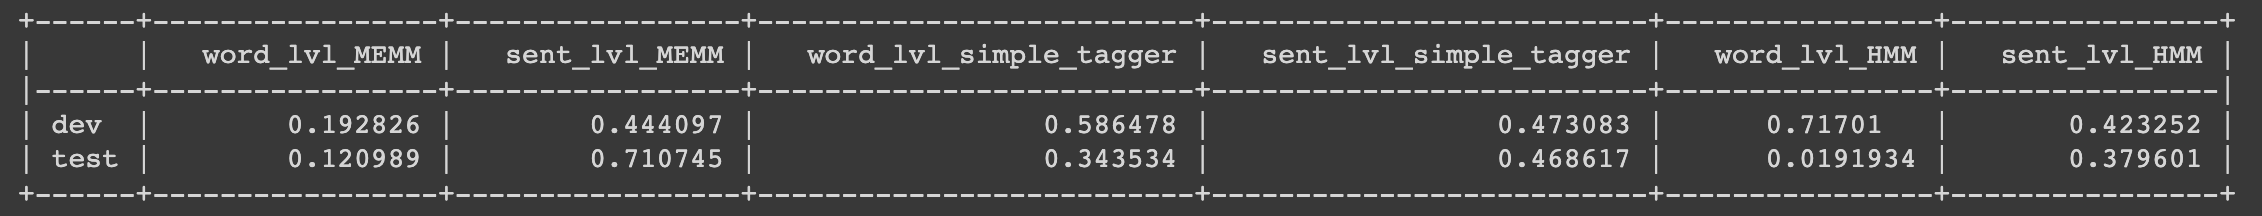



In [ ]:
# TO DO

# Random Example:
# results_acc = np.random.rand(2, 6)
# df_results = pd.DataFrame(results_acc,columns=['word_lvl_MEMM', 'sent_lvl_MEMM', 'word_lvl_simple_tagger', 'sent_lvl_simple_tagger', 'word_lvl_HMM', 'sent_lvl_HMM'])
# df_results.index = ['dev','test']
# print(tabulate(df_results, headers='keys', tablefmt='psql'))

**Improved Tagger**  

*This is an open question.*

Base on your general knowlege in the filed of ML, and what you learned in the NLP course so far;  
Create your own tagger, and **make sure to improve the scores on the test dataset.**

In [ ]:
class improved_tagger:
  def __init__(self):
    # TO DO
    pass

  def train(self, data) -> None:
    # TO DO
    pass

  def evaluate(self, data) -> tuple[int,int]:
    # TO DO
    pass

**Train & Evaluate**  
Use the class you created to train and evaluate your model.
Save & Print the eveluation scores.


In [ ]:
# TO DO

## Part 6 - Results

Print your results in the following format:


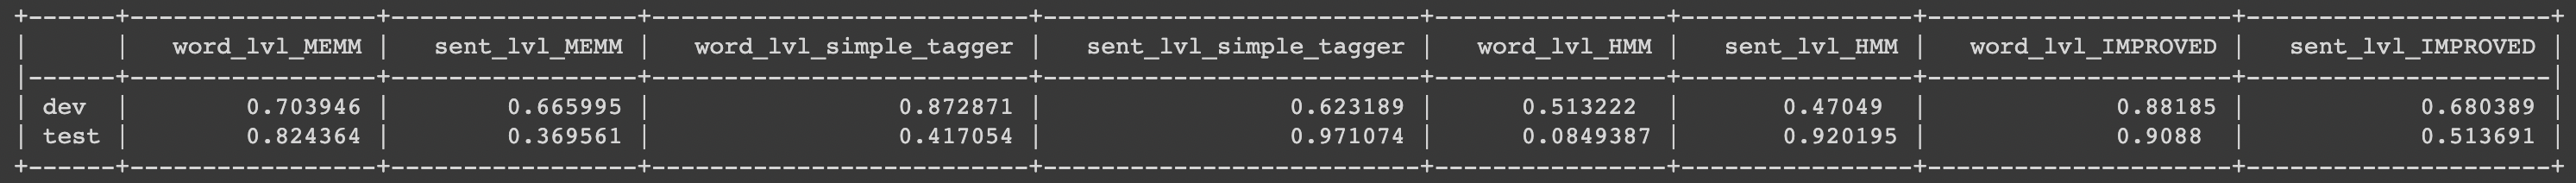

In [ ]:
# TO DO

Save the results in the dataframe to a CSV using this format:  
> `{student_ID1}_{Student_ID2}_part6.csv`  
> For example: 300123123_200321321_part6.csv

In [ ]:
# TO DO

<br><br><br>
Good Luck.